<a href="https://colab.research.google.com/github/mldurga/projects/blob/master/wagon_shipment_reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Wagon shipment no scanner

[PaddleOCR](https://github.com/PaddlePaddle/PaddleOCR) models used here for reading the wagon number. 

In [ ]:
!pip install paddlepaddle paddleocr -Uqq

In [60]:
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image
# import gradio as gr
import torch
import re

In [61]:
region={'CR', 'KR', 'NR', 'NCR', 'NER', 'NFR', 'NWR', 'ER', 'ECR', 'ECOR',
       'SR', 'SCR', 'SCOR', 'SER', 'SECR', 'SWR', 'WR', 'WCR'}
wagon={'steel_wagon':['BFNS','BOST','BOSTHS','BOXN','BRN','BRNA','BRNAHS'],'brake_van':['BVCM','BVZC','BVZI']}



In [67]:
ocr = PaddleOCR(use_angle_cls=True, lang='en',use_gpu=False)
img_path='/content/wag3.jpeg'
result = ocr.ocr(img_path, cls=True)
outs = [line[1][0] for line in result]
txts=[item.upper() for sublist in [re.findall("[a-zA-Z]+",o) for o in outs] for item in sublist]
num=[item for sublist in [re.findall(r'\d+',o) for o in outs] for item in sublist]

[2021/12/15 07:02:38] root WARNING: lang en is not support in PP-OCRv2, auto switch to version PP-OCR
[2021/12/15 07:02:38] root WARNING: lang en is not support in PP-OCRv2, auto switch to version PP-OCR
[2021/12/15 07:02:38] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/2.3.0.2/ocr/det/en/en_ppocr_mobile_v2.0_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_t

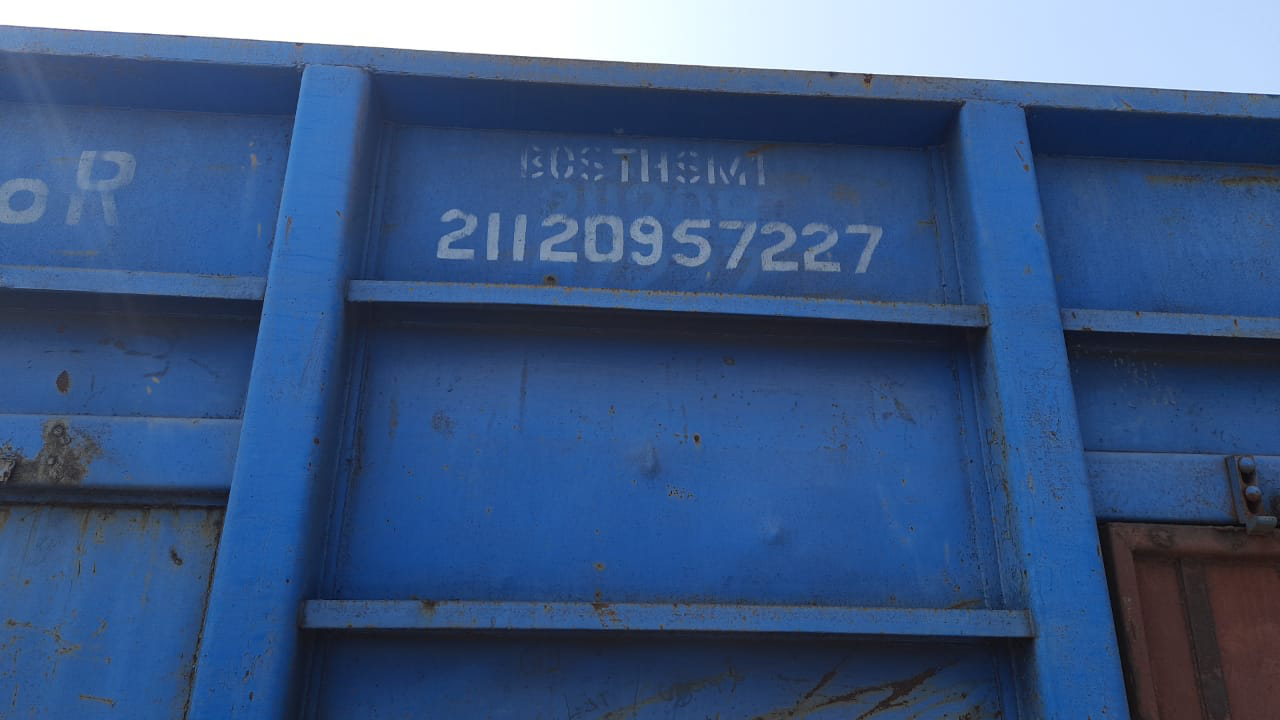

In [68]:
Image.open(img_path)

In [69]:
print(num)
print(txts)

['0748', '1', '21120957227']
['OR', 'C', 'M']
